GEOGCS["GCS_NepalDD",DATUM["D_Everest_Bangladesh",SPHEROID["Everest 1830 (1937 Adjustment)",6377276.345,300.8017,AUTHORITY["EPSG","7015"]]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]
CSV districts: 68
Shapefile districts: 77


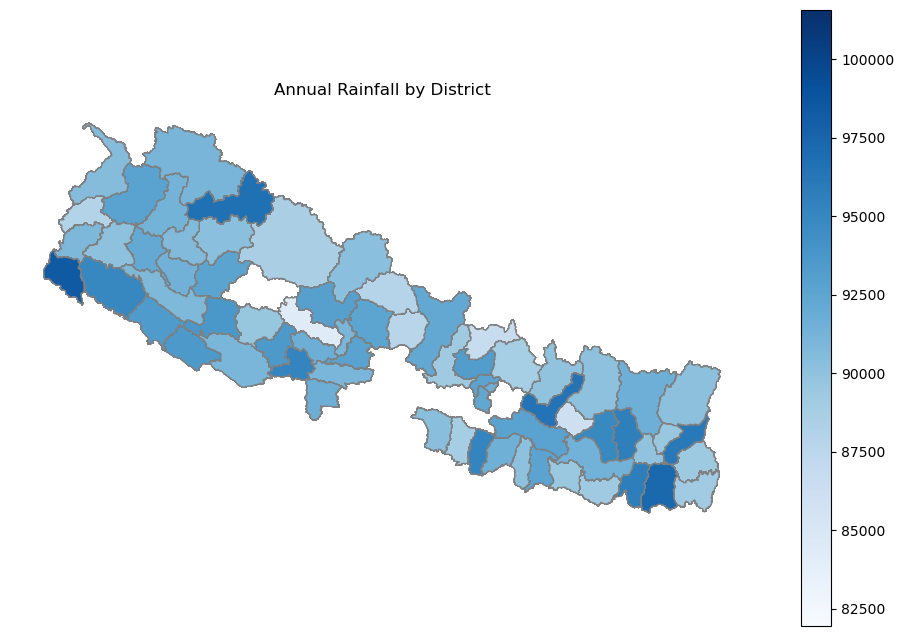

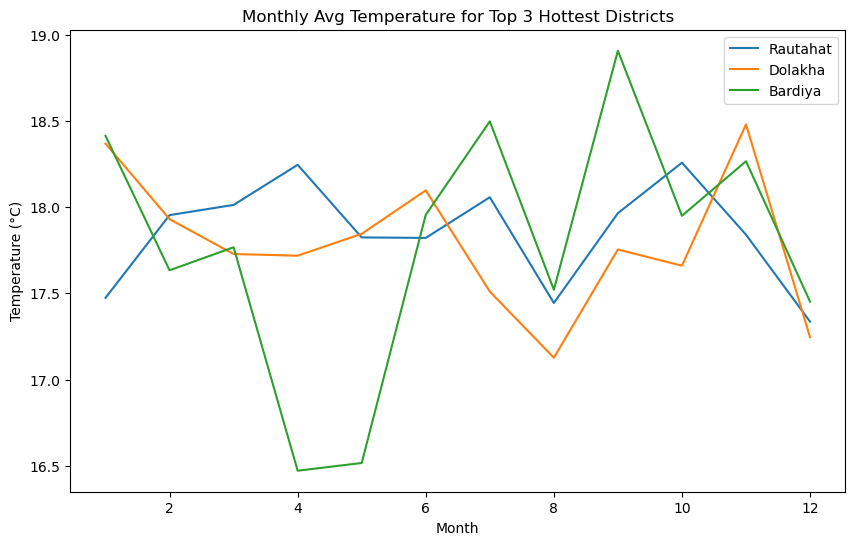

In [1]:
# Nepal Geospatial Data Analysis

## 1. Setup and Imports


# Data manipulation
import pandas as pd
import numpy as np

# Geospatial libraries
import geopandas as gpd
from shapely.geometry import Point

# Visualization
import matplotlib.pyplot as plt
import folium
from folium import Choropleth, CircleMarker, LayerControl

# Machine learning & preprocessing
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)


## 2. Load Data


# Load daily climate data
climate_df = pd.read_csv('/Users/vizon/github-classroom/Omdena-NIC-Nepal/capstone-project-Vizon15/datasets/nepal_gis_daily_data.csv', parse_dates=['Date'])
climate_df.head()



# Load district shapefile (ensure .shp/.shx/.dbf are together)
shapefile_path = '/Users/vizon/github-classroom/Omdena-NIC-Nepal/capstone-project-Vizon15/datasets/district_shape/district.shp'
districts_gdf = gpd.read_file(shapefile_path)
districts_gdf.head()
print(districts_gdf.crs)

## 3. Harmonize District Names

# Harmonize District Names (Convert to Title Case)
climate_df['District'] = climate_df['District'].str.title()  # Convert climate data
districts_gdf['DISTRICT'] = districts_gdf['DISTRICT'].str.title()  # Convert shapefile data
districts_gdf.rename(columns={'DISTRICT': 'District'}, inplace=True)  # Rename column

# Filter climate data to only include districts in the shapefile
common_districts = climate_df['District'].isin(districts_gdf['District'])
climate_df = climate_df[common_districts]
# Convert shapefile district names from ALL CAPS to Title Case and rename column
if 'DISTRICT' in districts_gdf.columns:
    districts_gdf['DISTRICT'] = districts_gdf['DISTRICT'].str.title()
    districts_gdf.rename(columns={'DISTRICT': 'District'}, inplace=True)

# Ensure naming consistency
print("CSV districts:", climate_df['District'].nunique())
print("Shapefile districts:", districts_gdf['District'].nunique())


## 4. Merge Climate Data with Geometries


# Example: aggregate annual rainfall by district
annual_rain = (
    climate_df
    .groupby([climate_df['Date'].dt.year, 'District'])['Rainfall (mm)']
    .sum()
    .reset_index()
)
annual_rain.columns = ['Year', 'District', 'Annual_Rainfall_mm']

# Merge with shapefile GeoDataFrame
rain_gdf = districts_gdf.merge(annual_rain, on='District', how='left')
rain_gdf.crs = districts_gdf.crs


## 5. Data Cleaning & Feature Engineering


# 5.1 Impute missing Temperature and Precipitation values
imputer = KNNImputer(n_neighbors=5)
climate_df[['Temperature (°C)', 'Precipitation (mm)']] = imputer.fit_transform(
    climate_df[['Temperature (°C)', 'Precipitation (mm)']]
)

# 5.2 Normalize Floods and Drought occurrences
scaler = MinMaxScaler()
climate_df['Floods_norm'] = scaler.fit_transform(climate_df[['Floods']])
climate_df['Drought_norm'] = scaler.fit_transform(climate_df[['Drought']])

# 5.3 Feature engineering: month, temperature anomaly
climate_df['Month'] = climate_df['Date'].dt.month
climate_df['Temp_Anomaly'] = (
    climate_df['Temperature (°C)']
    - climate_df.groupby('District')['Temperature (°C)'].transform('mean')
)


## 6. Spatial Analysis & Visualization

### 6.1 Static Choropleth Map of Annual Rainfall


fig, ax = plt.subplots(figsize=(12, 8))
rain_gdf.plot(
    column='Annual_Rainfall_mm', cmap='Blues', linewidth=0.8,
    edgecolor='gray', legend=True, ax=ax
)
ax.set_title('Annual Rainfall by District')
ax.axis('off')
plt.show()


### 6.2 Interactive Folium Map


# Initialize map centered on Nepal
m = folium.Map(location=[28.4, 84.1], zoom_start=7, tiles='CartoDB positron')

# Add choropleth layer for annual rainfall
Choropleth(
    geo_data=rain_gdf,
    name='Annual Rainfall',
    data=rain_gdf,
    columns=['District', 'Annual_Rainfall_mm'],
    key_on='feature.properties.District',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Annual Rainfall (mm)'
).add_to(m)

# Mark extreme flood events (>95th percentile)
flood_threshold = climate_df['Floods'].quantile(0.95)
extreme_floods = climate_df[climate_df['Floods'] > flood_threshold]

# Reproject to a projected CRS (e.g., UTM zone appropriate for Nepal)
projected_gdf = districts_gdf.to_crs(epsg=32645)  # UTM Zone 45N

for _, row in extreme_floods.iterrows():
    try:
        # Handle potential KeyError if district is not found in shapefile
        centroid = projected_gdf.loc[
            projected_gdf['District'] == row['District'], 'geometry'
        ].centroid.iloc[0].coords[0]

        CircleMarker(
            location=[centroid[1], centroid[0]],
            radius=3,
            color='red',
            fill=True,
            fill_opacity=0.7
        ).add_to(m)
    except (KeyError, IndexError):
        # Print a warning if a district is not found
        print(f"Warning: District '{row['District']}' not found in shapefile.")
        continue  # Skip to the next iteration of the loop
## 7. District-level Exploratory Analysis


# Seasonal average temperature per district
seasonal_temp = (
    climate_df
    .groupby(['District', 'Month'])['Temperature (°C)']
    .mean()
    .reset_index()
)

# Identify top 3 hottest districts overall
top3 = (
    seasonal_temp
    .groupby('District')['Temperature (°C)']
    .mean()
    .nlargest(3)
    .index
)

# Plot monthly temperature trends for top 3
plt.figure(figsize=(10, 6))
for dist in top3:
    subset = seasonal_temp[seasonal_temp['District'] == dist]
    plt.plot(
        subset['Month'], subset['Temperature (°C)'], label=dist
    )
plt.title('Monthly Avg Temperature for Top 3 Hottest Districts')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()


## 8. Save Preprocessed DataFrames to CSV

# Save climate_df to a new CSV file
climate_df.to_csv('preprocessed_climate_data.csv', index=False)

# Save districts_gdf to a new CSV file
districts_gdf.to_csv('preprocessed_districts.csv', index=False)

# Save rain_gdf to a new CSV file (if you want to use it in the EDA)
rain_gdf.to_csv('preprocessed_annual_rain.csv', index=False)

# Save seasonal_temp to a new CSV file (if you want to use it in the EDA)
seasonal_temp.to_csv('preprocessed_seasonal_temp.csv', index=False)